##Group Convolutional Network
In this notebook i will implement an algorithm with group convolutional layers. The group convolution is a generalized concept of convolution that allow to preserve the equivariance with respect to a specific group transformation. After the implementation, the algorithm will be tested and compared with a standard CNN.


Import some useful packages 

In [2]:
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
from typing import Mapping, Union, Optional

import argparse
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.optim as optim
import plotly.graph_objects as go
import torchvision
from torchvision import datasets, models, transforms
import os
from tqdm.notebook import tqdm,trange
import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from __future__ import print_function, division


In [17]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Rotation Group C4
Let's start with the definition of the group of $C_4$, the group of rotation for a multiple angles of $\frac{\pi}{2}$.
$$ C_4= \{ R_{0}, R_{\frac{\pi}{2}},R_{\pi},R_{3 \frac{\pi}{2}} \} = \{R_{r \frac{\pi}{2}} | \,\, r=0,1,2,3 \}
$$
This group can be implemented by taking into account that the product rule bethween 2 element of this group is
$$
R_{r \frac{\pi}{2}} \cdot R_{s \frac{\pi}{2}} = R_{(r + s \mod 4) \frac{\pi}{2}}
$$
with this relation is possible to fulfill the two hypotesis that define a group (associativity and inverse).

For group mathematical definition see: https://en.wikipedia.org/wiki/Group_(mathematics)#Definition 

In [4]:
class C4:

  @staticmethod
  def product(r: int, s: int) -> int:
    #the input must be a couple of integers in {0,1,2,3}

    return (r+s)%4

  
  @staticmethod
  def inverse(r: int) -> int:

    #the input here is a an integer in {0,1,2,3}

    a=4-r

    if r==0:
      a=0

    return a



#Rotation and Traslation: p4 Group
Starting from the $C4$ group, is possible to define the $p4$. $p4$ is the group of translations and rotations by multiples of $\frac{\pi}{2}$. An element in this group is defined by a tuple $(h,w,r)$ with $h$ and $w \in \mathbb{Z}$  and $r \in C_4$.
Usually is possible to use the notation $(\textbf{t},r)$ with $\textbf{t}=(h,w)$. In the following function, after a specific rotation of a set of images, the tensor is permutated in the index of $r$ w.r.t. the new orientation. This feature is necessary for guarantee the main features of group convolution, like the equivariance. A function is said to be an equivariant map when its domain and codomain are acted on by the same symmetry group, and when the function commutes with the action of the group. That is, applying a symmetry transformation and then computing the function produces the same result as computing the function and then applying the transformation.

Group action Definition: https://en.wikipedia.org/wiki/Group_action#Definition

In [5]:
def rotate(x: torch.Tensor, r: int) -> torch.Tensor:
  # 'rotate' give back a x tensor rotated r times pi/2
  return x.rot90(r, dims=(-2, -1))

def rotate_p4(y: torch.Tensor, r: int) -> torch.Tensor:
  # `y` is a function of p4, basically have 't' a position and an orientation 'r'
  # the last two dimensions (`dim=-2` and `dim=-1`) of `y` are the spatial dimensions
  # `dim=-3` has size `4` and is the C_4 dimension.

  rotating_y=torch.rot90(y,r, dims=(-2, -1))
  permuted_y=torch.empty(rotating_y.shape)

  for i in range(4):
    permuted_y[...,C4.product(i,r),: ,:]=rotating_y[...,i,:,:] # The permutation of index in according to the rotation 

  return permuted_y



Quick check of the `rotate_p4` function, here we can see  the correct permutation of the index




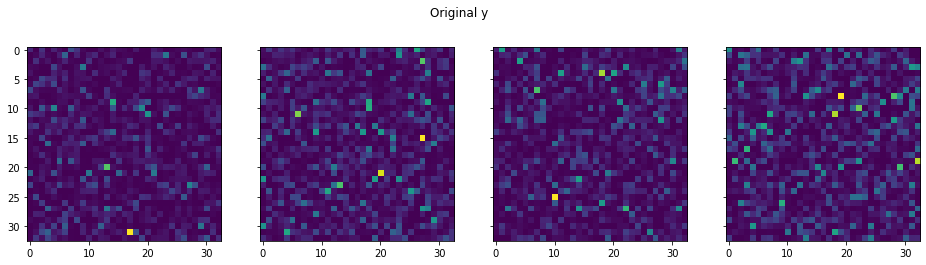

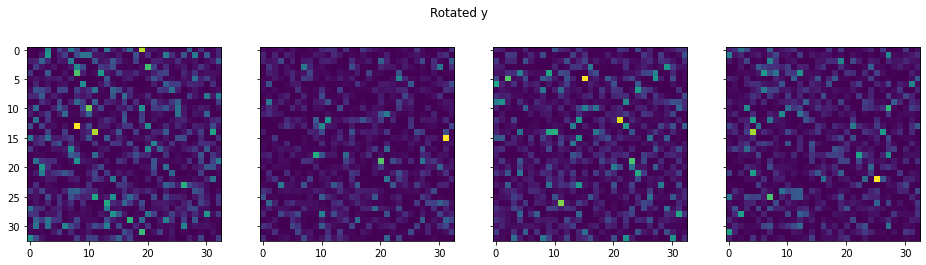

In [6]:
y = torch.randn(1, 1, 4, 33, 33)**2


ry = rotate_p4(y, 1)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()


#Group Convolution
Let $X$ be the space where the initial dataset is defined, like for example an image with some given input channels. If $\psi \in X$ is the filter and $x \in X$ the initial data, the group convolution $\psi \star x$ is defined as:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} \mathbf{p})\ x(\mathbf{p})
                                 = \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi(r^{-1} (\mathbf{p} - \mathbf{t}))\ x(\mathbf{p})
$$
The important point here is that the new convoluted function is now a function of $p4$, we have a different value for each transformation $(\textbf{t},r)$ applied to the filter. In this sense, is possible to say that the output function is defined in another space $Y$ bigger than the starter one $X$. We have this because the operations of convolution and rotation are not equivariant, in other words, the product of this operator is not close in the space $X$.

---



##Lifting Convolution

The shifting from the two spaces $X \rightarrow Y$ is the starting point for every G-CNN. This operation is called $\textbf{lifting convolution}$ since we have the mapping $X$ to a bigger dimension $Y$. This switch, can be implemented by generating a 4-channles image $y(\textbf{t})=y(\textbf{t},r=i)  \in \mathbb{R}$ where $i$ give the i-th orientation of the image.
In this case, $Y$ is the space of all functions $y: p4 \rightarrow \mathbb{R}$. In $Y$ every function have an action of the generic group $p4$ on it:
$$
  [(\mathbf{t}, r).y](\mathbf{p}, s) := y((\mathbf{t}, r)^{-1} \cdot (\mathbf{p}, s)) = y(r^{-1}(\mathbf{p} - \mathbf{t}), r^{-1}s)
$$

This relation is possible  beacuse in group theory we can define a generic $\textbf{action}$ of a group $G$ on the element's functions, in this case we use the following:
$$
  [g.x](h) := x(g^{-1} \cdot h)
$$
where $g, h \in G$ and  $x: G \to \mathbb{R}$ is an element of a generic function. In the first equality we used the the definition simbol $:=$ indeed, it is always possible to define an action of this kind (it can be done if the action fulfill the group action definition). The second equality is instead possible by keep in mind that, a rotation $r^{-1}$ must be applied to the $s$ orientation by using the product of $C_4$ described before, and the traslation $(r^{-1} \textbf{p-t})$ is basically the action of the traslation operator taking into account the previous rotation of the system. The third step of this equality is the reason beacuse it's necessary to permute the image conforming to the given rotation (`rotate_p4` function)  : the action of the rotation affect both the rotation itself  and the traslation, so we need to reorient the pixels correctly before the traslation.

The lifting convolution can be realized by creating 4 rotated copies of a single filter (in this specific case we have only 4 orientation, this number depends on the group) and using  the usual `torch.conv2d` (https://arxiv.org/pdf/1602.07576.pdf). The image is convolved for each copy independently to generate 4 different output images, one for each rortation. In this sense, we start from a space with a single dimension and obtain an output (in space $Y$) of 4 images.

In [7]:
class LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
  
    # weights inizialized with random values from a normal distribution with std = 1 / sqrt(out_channels * in_channels)

    self.weight = None

    self.weight=Parameter(torch.empty(self.out_channels*self.in_channels*self.kernel_size*self.kernel_size).normal_(mean=0,std=1/np.sqrt(self.out_channels*self.in_channels)))
    
    self.bias = None
    if bias:

      self.bias=Parameter(torch.empty(self.out_channels).normal_(mean=0,std=1/np.sqrt(self.out_channels)))
  
  def build_filter(self) ->torch.Tensor:
   
    # - the `out_channels x 4 x in_channels x kernel_size x kernel_size` filter
    # - the `out_channels x 4` bias
    
    _filter = None
    _bias = None

    filtro_base=self.weight.reshape(self.out_channels,self.in_channels, self.kernel_size,self.kernel_size)
    r=[rotate(filtro_base,i+1) for i in range(3)]
    _filter= torch.stack((filtro_base,r[0],r[1],r[2]),dim=1)

    if self.bias is not None:
    
      _bias=torch.stack((self.bias,self.bias,self.bias,self.bias),dim=1) 

    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    if self.bias is not None:
      assert _bias.shape == (self.out_channels, 4)

    assert _filter.shape == (self.out_channels, 4, self.in_channels, self.kernel_size, self.kernel_size)

    # for use torch.conv2d,the filter and bias are reshaped in order to stack together all filters

    _filter = _filter.reshape(self.out_channels * 4, self.in_channels, self.kernel_size, self.kernel_size)

    if self.bias is not None:
      _bias = _bias.reshape(self.out_channels * 4)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])


##Checking Equivariance

Let's see if this layer fulfill the equivariance definition. The equivariance guarantee that this operation is structure preserving (https://arxiv.org/pdf/1602.07576.pdf). mathematically it can written as:
$$
\Phi (T_g x) = T_g \Phi (x)
$$


In [8]:
#just some arbitrary dimensions..

in_channels = 1
out_channels = 5
kernel_size = 3
batchsize = 6
S = 33

layer = LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, S, S)

# the input image belongs to the space X, so we use the original action to rotate it
gx = rotate(x, 1)

psi_x = layer(x) 
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)


# check equivariance (here i'm imposing the relation of equivariance seen before)
assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)
#Calculating the number of parameters, here they will be in_channels*out_cannels*kernels_size**2 + bias
#where bias has the dimension of the output_channel
print("Number of parameters of this lifting layer :",sum(x.numel() for x in layer.parameters() if x.requires_grad))


Number of parameters of this lifting layer : 50


A lifting layer is an object that maps an input in the space $X$ into an output in $Y$. This means that we cannot directly feed the output of the lifting layer into another lifting layer. For build a deep architecture, we must develop a layer that simply goes from $Y$ to $Y$. Let's recall the definition of group convolution seen before:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} \mathbf{p})\ x(\mathbf{p})
$$
Notice that both the input image $x$ and the filter $\psi$ are functions of the plane $\mathbb{Z}^2$, but the feature map $\psi \star x$ is a function of the discrete group $G$. Hence, for all the layers after the first, the filters $\psi$ must also be a functions on $G$. With this intuition, by using the defintion of action of a group defined before ($
  [g.x](h) := x(g^{-1} \cdot h)
$), we can rewrite the operation of convolution for a generic layer after the first as:
$$
  [\psi \star x](g) := \sum_{h \in H} \psi(g^{-1} \cdot h)\ x(h)
$$
Note that here we are summing over the $h$, that are elements of the group $G$. In this way, the filter is rotated, so the operation $(\psi \star x)$ belongs to $Y$, the space of functions over the group $G$ (basically we have a function of $h$, element of the group). In the case of $G=p4$, the equation becomes:
$$
 [\psi \star x](\mathbf{t}, r) := \sum_{s \in C_4} \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} (\mathbf{p}, s))\ x(\mathbf{p}, s)
$$
By using the action of the group $g$ on the filter $\psi((\mathbf{t}, r)^{-1} (\mathbf{p}, s)) = \psi(r^{-1} (\mathbf{p} - \mathbf{t}, s)) = [r.\psi](\mathbf{p} - \mathbf{t}, s)$
the equation becomes:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{s \in C_4} \sum_{\mathbf{p} \in \mathbb{Z}^2} [r.\psi](\mathbf{p} - \mathbf{t}, s)\ x(\mathbf{p}, s)
$$
This equation can be seen ad the standard convolution (`torch.conv2d`)  $\sum_{\mathbf{p} \in \mathbb{Z}^2} [r.\psi](\mathbf{p} - \mathbf{t}, s)\ x(\mathbf{p}, s)$ of an image  $x(\cdot, s) : \mathbb{Z}^2 \to \mathbb{R}$ with the filter $[r.\psi](\cdot, s): \mathbb{Z}^2 \to \mathbb{R}$, for a fixed value of $s$. The group convolution of this kind can be implemented by using $4 \times 4$  `torch.conv2d` with normal filters. 
(https://arxiv.org/pdf/1602.07576.pdf)

In [9]:
class GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
  
    self.weight = None
    #inizialized starting from a normal distribution, with an sd given by the dimension of input*output.

    self.weight=Parameter(torch.empty(self.out_channels*self.in_channels*4*self.kernel_size*self.kernel_size).normal_(0.,1/np.sqrt(self.out_channels*self.in_channels)))

    self.bias = None

    if bias:

      self.bias=Parameter(torch.empty(self.out_channels).normal_(mean=0,std=1/np.sqrt(self.out_channels))) 
  
  def build_filter(self) ->torch.Tensor:
    # - the `out_channels x 4 x in_channels x 4 x kernel_size x kernel_size` filter
    # - the `out_channels x 4` bias
    
    _filter = None
    _bias = None

    filtro_base_rotate=self.weight.reshape(self.out_channels,self.in_channels,4,self.kernel_size,self.kernel_size)
    r=[rotate_p4(filtro_base_rotate,i+1) for i in range(3)]
    _filter=torch.stack((filtro_base_rotate,r[0],r[1],r[2]),dim=1)

    if self.bias is not None:

      _bias=torch.stack((self.bias,self.bias,self.bias,self.bias),dim=1) 
    
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()
    #stacking together the filters allow us to use torch.conv2d
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels * 4, self.kernel_size, self.kernel_size)

    if self.bias is not None:
      _bias = _bias.reshape(self.out_channels * 4)

    # this time, the input has shape `batch_size x in_channels x 4 x W x H`, it is indeed an element of the space Y
    # in order to use torch.conv2d, the input must be reshaped as `batch_size x in_channels*4 x W x H` 
    x = x.view(x.shape[0], self.in_channels*4, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # `batch_size x out_channels x 4 x W x H` is the expected final shape

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



Let's check again the equivariance, as we have seen before, by imposing the definition
$$
\Phi (T_g x) = T_g \Phi (x)
$$


In [11]:
#just some arbitrary dimensions..
in_channels = 3
out_channels = 10
kernel_size = 3
batchsize = 5
S = 33

layer = GroupConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, 4, S, S)**2
# the input image belongs to the space Y, this time the rotation must permute the index too.
gx = rotate_p4(x, 1)

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

# check equivariance (here i'm imposing the relation of equivariance seen before)
assert torch.allclose(psi_gx, g_psi_x, atol=1e-5, rtol=1e-5)

#Calculating the number of Learning parameters, this time they will be Input_channel*output_channels*4*kernel_size**2 + bias
#where the bias is a vector of dimension out_channels.
print("Number parameter of GroupConv2d:",sum(x.numel() for x in layer.parameters() if x.requires_grad))


Number parameter of GroupConv2d: 1090


#Deep Rotation Equivariant CNN (p4CNN)
##p4CNN for Rotated MNIST
Now it is possible to combine the two layers defined before and create a `torch.nn.Module` here we have a first *lifting layer* followed by *4 group convolution*. At each step a `ReLU` activation function is applied and a pooling. In this process of convolution, it is necessary to use a 3d pooling (I use `torch.nn.MaxPool3d)`. In the first layers we want to keep the rotational dimensions separate, in order to learn features from different orientation (`kernel_size=(1,3,3)`). In the last layer we want to use this information so the last layer basically pool over the rotational dimension too  (`kernel_size=(4,3,3)`). Here should be possible to use some other kind of decyclic layers in order to use the rotational informations given by the isotonic layers (layers that are put output in the same space of the input :https://arxiv.org/pdf/1705.08623.pdf). The simple rotational pooling operation basically coincide with the evaluation of the $\sum_s$ of the standard convolution (`torch.conv2d`) as described in the previous section.

In [12]:
class C4CNN(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(C4CNN, self).__init__()

    channels = [8, 16, 32, 64, 128]

    self.layerX_Y=nn.Sequential(
      LiftingConv2d(in_channels=1, out_channels=channels[0], kernel_size = 3, padding=1, bias=True),
      nn.MaxPool3d(kernel_size=(1,3,3),stride=(1,2,2),padding=(0,1,1)),
      nn.ReLU()
    )
    self.layer0=nn.Sequential(
      GroupConv2d(in_channels=channels[0], out_channels=channels[1], kernel_size = 3, padding=1, bias=True),
      nn.MaxPool3d(kernel_size=(1,3,3),stride=(1,2,2),padding=(0,1,1)),
      nn.ReLU()
    )
    self.layer1=nn.Sequential(
      GroupConv2d(in_channels=channels[1], out_channels=channels[2], kernel_size = 3, padding=1, bias=True),
      nn.MaxPool3d(kernel_size=(1,3,3),stride=(1,2,2),padding=(0,1,1)),
      nn.ReLU()
    )
    self.layer2=nn.Sequential(
      GroupConv2d(in_channels=channels[2], out_channels=channels[3], kernel_size =3, padding=1, bias=True),
      nn.MaxPool3d(kernel_size=(1,3,3),stride=(1,2,2),padding=(0,1,1)),
      nn.ReLU()
    )
    self.layer3=nn.Sequential(
      GroupConv2d(in_channels=channels[3], out_channels=channels[4], kernel_size = 3, padding=1, bias=True),
      nn.MaxPool3d(kernel_size=(4,3,3),stride=(1,1,1),padding=(0,0,0)),
      nn.ReLU()
    )
    self.fc1=nn.Linear(channels[4] ,n_classes)
    self.fc2=nn.Linear(n_classes,n_classes)

  def forward(self, input: torch.Tensor)->torch.Tensor:

    input=self.layerX_Y(input)
    input=self.layer0(input)
    input=self.layer1(input)
    input=self.layer2(input)
    input=self.layer3(input)
    input = input.view(input.shape[0], -1)
    input=self.fc1(input)
  
    return input


In conclusion we can check if this network is **invariant** under rotation, this basically means that the network must fulfill the relation:
$$
\Phi(T_g x )= \Phi(x)
$$
which means that the result for a system and the same system rotated give us the same result.

In [13]:
net = C4CNN()

x = torch.randn(5, 1, 33, 33)
y = net(x)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

#notice that in the linear layers  bias=true, just like conv2d
sum(x.numel() for x in net.parameters() if x.requires_grad)

393400

## Standard CNN for rotated MNIST
Let's implement another network that is a standard CNN to compare the results with the p4CNN. The CNN used is a CNN with the same number of parameters of the previous one in order to have a fair comparison.

In [14]:
class CNN(nn.Module):
  def __init__(
        self, input_channels=1, n_classes=10
    ) -> None:

        super().__init__()
        
        channels = [16, 32, 64,128,256]


        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=channels[0], kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )


        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=3),           
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=3),          
            nn.ReLU()
        )
         
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=channels[3], out_channels=channels[4], kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.fc1=nn.Linear(channels[4] ,n_classes)
    
  def forward(self, input: torch.Tensor)->torch.Tensor:

    input=self.layer0(input)
    input=self.layer1(input)
    input=self.layer2(input)
    input=self.layer3(input)
    input=self.layer4(input)
    input = input.view(input.shape[0], -1)
    input=self.fc1(input)
  
    return input

In [15]:
network_base = CNN()



In order to have the same number of parameters in the network, the number of parameters of the classic CNN must be increased. As explained: " To evaluate G-CNNs, we replaced all convolution layers of the baseline architectures by p4 or p4m convolutions. For a
constant number of filters, this increases the size of the feature maps 4 or 8-fold, which in turn increases the number of
parameters required per filter in the next layer. Hence, we
halve the number of filters in each p4-conv layer, and divide
it by roughly $
\sqrt{8} ≈ 3 $ in each p4m-conv layer. This way,
the number of parameters is left approximately invariant "  (https://arxiv.org/pdf/1602.07576.pdf). So for this reason, the number parameters of the standard CNN are doubled w.r.t. the p4CNN.


In [16]:
sum(x.numel() for x in network_base.parameters() if x.requires_grad)

394890

We find approximately the same number of parameters.

##p4CNN tested on rotated MNIST

The rotated MNIST dataset, is a datasete composed by rotated digits for a degree uniformly drawn from $[0, 2 \pi]$. The dataset is made by $12000$ images for training and validation and $50000$ for testing.

In [21]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# uncompress the zip file
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

File ‘mnist_rotation_new.zip’ already there; not retrieving.

Archive:  mnist_rotation_new.zip


In [22]:
class MnistRotDataset(Dataset):
    
    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']
            
        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"
        
        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')
        
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)    
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images in MNIST are only 28x28
        # we pad them to have shape 33 x 33
        self.images = np.pad(self.images, pad_width=((0,0), (2, 3), (2, 3)), mode='edge')

        assert self.images.shape == (self.labels.shape[0], 33, 33)
    
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)


train_set = MnistRotDataset('train', ToTensor())
test_set = MnistRotDataset('test', ToTensor())

The dimension of the images are increased with padding, in this way we can perform an higher number of convolution in the same network.

Some image in the training set:

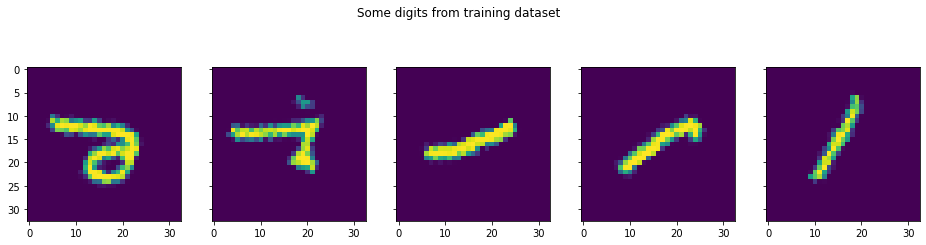

In [23]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(5):
  j=torch.randint(low=0,high=train_set.__len__(),size=(1,)) 
  axes[i].imshow(train_set.__getitem__(j)[0][0].numpy())
fig.suptitle('Some digits from training dataset')
plt.show()


In [24]:
epochs=30

In [31]:
def train_model(model: torch.nn.Module):

  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

  valid_size=0.2 #percetage of training set that goes in validation
  num_workers=0
  valid_loss_min=np.inf

  num_train = len(train_set)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)


  train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
        sampler=train_sampler, num_workers=num_workers)
  valid_loader = torch.utils.data.DataLoader(train_set, batch_size=64, 
        sampler=valid_sampler, num_workers=num_workers)
  
  model.to(device)
  
  for epoch in trange(epochs, desc="Training"):
    train_loss=0.0
    valid_loss=0.0
    model.train()
    for i, (x, t) in enumerate(tqdm.tqdm(train_loader, position=0, leave=True)):
        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()

        train_loss+=loss.item()*x.size(0) #taking the loss and multiply it for the batch size

    model.eval()
    for x,t in valid_loader:
        x,t=x.to(device),t.to(device)
        y=model(x)
        loss=loss_function(y,t)
        valid_loss+=loss.item()*x.size(0)

    train_loss=train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print(f"Training Loss :{train_loss:.6f}")
    print(f"Validation Loss :{valid_loss:.6f}")
    #saving the model if the validation loss decrease
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_MNIST.pt')
      valid_loss_min = valid_loss
  return model





def test_model(model: torch.nn.Module):
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
  total = 0
  correct = 0
  accuracy=0
  test_loss=0.0
  class_correct=list(0. for i in range(10))
  class_total=list(0. for i in range(10))
  with torch.no_grad():
      model.eval()
      for i, (x, t) in enumerate(tqdm.tqdm(test_loader, position=0, leave=True,
                                           colour="red", desc=" Test ")):

          x = x.to(device)
          t = t.to(device)
          
          y = model(x)

          _, prediction = torch.max(y.data, 1)
          correct_tensor = prediction.eq(t.view_as(prediction))
          correct=torch.squeeze(correct_tensor)
          for i in range(t.shape[0]):
            label = t.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
      print("\n")
      for i in range(10):
        if class_total[i] > 0:
            print(' Test Accuracy of %2s: %2d%% (%2d/%2d)' % (
               i , 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
           print('Test Accuracy of %5s: N/A (no training examples)' % (i))

      print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
          100. * np.sum(class_correct) / np.sum(class_total),
          np.sum(class_correct), np.sum(class_total)))


In [33]:
model_standard=CNN()
model_standard=train_model(model_standard)

test_model(model_standard)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


Training Loss :1.821454
Validation Loss :0.435146
Validation loss decreased (inf --> 0.435146).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


Training Loss :1.473161
Validation Loss :0.328947
Validation loss decreased (0.435146 --> 0.328947).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


Training Loss :1.197844
Validation Loss :0.292795
Validation loss decreased (0.328947 --> 0.292795).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


Training Loss :1.072402
Validation Loss :0.270062
Validation loss decreased (0.292795 --> 0.270062).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


Training Loss :0.966123
Validation Loss :0.247853
Validation loss decreased (0.270062 --> 0.247853).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


Training Loss :0.881375
Validation Loss :0.233769
Validation loss decreased (0.247853 --> 0.233769).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.00it/s]


Training Loss :0.816820
Validation Loss :0.213427
Validation loss decreased (0.233769 --> 0.213427).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


Training Loss :0.752771
Validation Loss :0.199624
Validation loss decreased (0.213427 --> 0.199624).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


Training Loss :0.699977
Validation Loss :0.194648
Validation loss decreased (0.199624 --> 0.194648).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.06it/s]


Training Loss :0.651018
Validation Loss :0.182509
Validation loss decreased (0.194648 --> 0.182509).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.99it/s]


Training Loss :0.614482
Validation Loss :0.172033
Validation loss decreased (0.182509 --> 0.172033).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.95it/s]


Training Loss :0.578292
Validation Loss :0.170171
Validation loss decreased (0.172033 --> 0.170171).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.96it/s]


Training Loss :0.550264
Validation Loss :0.164710
Validation loss decreased (0.170171 --> 0.164710).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.93it/s]


Training Loss :0.523251
Validation Loss :0.152502
Validation loss decreased (0.164710 --> 0.152502).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.95it/s]


Training Loss :0.495514
Validation Loss :0.148877
Validation loss decreased (0.152502 --> 0.148877).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.96it/s]


Training Loss :0.473088
Validation Loss :0.144009
Validation loss decreased (0.148877 --> 0.144009).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.98it/s]


Training Loss :0.454132
Validation Loss :0.141278
Validation loss decreased (0.144009 --> 0.141278).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.96it/s]


Training Loss :0.436198
Validation Loss :0.137015
Validation loss decreased (0.141278 --> 0.137015).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


Training Loss :0.415684
Validation Loss :0.135622
Validation loss decreased (0.137015 --> 0.135622).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.92it/s]


Training Loss :0.398676
Validation Loss :0.129915
Validation loss decreased (0.135622 --> 0.129915).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.98it/s]


Training Loss :0.388122
Validation Loss :0.129828
Validation loss decreased (0.129915 --> 0.129828).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


Training Loss :0.366675
Validation Loss :0.124266
Validation loss decreased (0.129828 --> 0.124266).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.94it/s]


Training Loss :0.363209
Validation Loss :0.118411
Validation loss decreased (0.124266 --> 0.118411).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.93it/s]


Training Loss :0.350636
Validation Loss :0.119672


100%|██████████| 150/150 [00:18<00:00,  7.98it/s]


Training Loss :0.334127
Validation Loss :0.115193
Validation loss decreased (0.118411 --> 0.115193).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.93it/s]


Training Loss :0.319939
Validation Loss :0.117682


100%|██████████| 150/150 [00:18<00:00,  7.94it/s]


Training Loss :0.308763
Validation Loss :0.116540


100%|██████████| 150/150 [00:18<00:00,  8.00it/s]


Training Loss :0.297790
Validation Loss :0.110966
Validation loss decreased (0.115193 --> 0.110966).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


Training Loss :0.294615
Validation Loss :0.108931
Validation loss decreased (0.110966 --> 0.108931).  Saving model ...


100%|██████████| 150/150 [00:18<00:00,  7.99it/s]


Training Loss :0.280772
Validation Loss :0.113482


 Test : 100%|██████████| 782/782 [00:35<00:00, 22.12it/s]




 Test Accuracy of  0: 95% (4763/4999)
 Test Accuracy of  1: 97% (5505/5668)
 Test Accuracy of  2: 79% (3969/4965)
 Test Accuracy of  3: 80% (4130/5108)
 Test Accuracy of  4: 67% (3240/4804)
 Test Accuracy of  5: 87% (3973/4537)
 Test Accuracy of  6: 73% (3630/4971)
 Test Accuracy of  7: 81% (4234/5221)
 Test Accuracy of  8: 88% (4314/4864)
 Test Accuracy of  9: 82% (4003/4863)

Test Accuracy (Overall): 83% (41761/50000)


Let's finally test our p4CNN:

In [34]:
model = C4CNN()

model = train_model(model)
test_model(model)


Training:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


Training Loss :1.709253
Validation Loss :0.367776
Validation loss decreased (inf --> 0.367776).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


Training Loss :1.292889
Validation Loss :0.285585
Validation loss decreased (0.367776 --> 0.285585).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.76it/s]


Training Loss :0.954600
Validation Loss :0.197114
Validation loss decreased (0.285585 --> 0.197114).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


Training Loss :0.692387
Validation Loss :0.162974
Validation loss decreased (0.197114 --> 0.162974).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


Training Loss :0.541236
Validation Loss :0.137203
Validation loss decreased (0.162974 --> 0.137203).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.76it/s]


Training Loss :0.452954
Validation Loss :0.113304
Validation loss decreased (0.137203 --> 0.113304).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.76it/s]


Training Loss :0.398867
Validation Loss :0.097794
Validation loss decreased (0.113304 --> 0.097794).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.77it/s]


Training Loss :0.353253
Validation Loss :0.086853
Validation loss decreased (0.097794 --> 0.086853).  Saving model ...


100%|██████████| 150/150 [00:54<00:00,  2.77it/s]


Training Loss :0.324761
Validation Loss :0.090106


100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


Training Loss :0.296935
Validation Loss :0.080561
Validation loss decreased (0.086853 --> 0.080561).  Saving model ...


100%|██████████| 150/150 [00:55<00:00,  2.71it/s]


Training Loss :0.277374
Validation Loss :0.078105
Validation loss decreased (0.080561 --> 0.078105).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.68it/s]


Training Loss :0.264295
Validation Loss :0.063242
Validation loss decreased (0.078105 --> 0.063242).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.68it/s]


Training Loss :0.244734
Validation Loss :0.064787


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Training Loss :0.226150
Validation Loss :0.069704


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Training Loss :0.220743
Validation Loss :0.064209


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Training Loss :0.204705
Validation Loss :0.061249
Validation loss decreased (0.063242 --> 0.061249).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.200967
Validation Loss :0.056840
Validation loss decreased (0.061249 --> 0.056840).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.185630
Validation Loss :0.053888
Validation loss decreased (0.056840 --> 0.053888).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.180455
Validation Loss :0.054674


100%|██████████| 150/150 [00:56<00:00,  2.63it/s]


Training Loss :0.169875
Validation Loss :0.053057
Validation loss decreased (0.053888 --> 0.053057).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.63it/s]


Training Loss :0.165075
Validation Loss :0.061899


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.162264
Validation Loss :0.054096


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.152226
Validation Loss :0.051013
Validation loss decreased (0.053057 --> 0.051013).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.147549
Validation Loss :0.048377
Validation loss decreased (0.051013 --> 0.048377).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.140955
Validation Loss :0.047974
Validation loss decreased (0.048377 --> 0.047974).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.144089
Validation Loss :0.045421
Validation loss decreased (0.047974 --> 0.045421).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.63it/s]


Training Loss :0.132617
Validation Loss :0.057551


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.136714
Validation Loss :0.045378
Validation loss decreased (0.045421 --> 0.045378).  Saving model ...


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Training Loss :0.131939
Validation Loss :0.045231
Validation loss decreased (0.045378 --> 0.045231).  Saving model ...


100%|██████████| 150/150 [00:57<00:00,  2.62it/s]


Training Loss :0.122334
Validation Loss :0.042922
Validation loss decreased (0.045231 --> 0.042922).  Saving model ...


 Test : 100%|██████████| 782/782 [02:09<00:00,  6.06it/s]



 Test Accuracy of  0: 97% (4892/4999)
 Test Accuracy of  1: 98% (5575/5668)
 Test Accuracy of  2: 94% (4708/4965)
 Test Accuracy of  3: 88% (4507/5108)
 Test Accuracy of  4: 97% (4667/4804)
 Test Accuracy of  5: 94% (4308/4537)
 Test Accuracy of  6: 93% (4635/4971)
 Test Accuracy of  7: 88% (4617/5221)
 Test Accuracy of  8: 93% (4547/4864)
 Test Accuracy of  9: 85% (4134/4863)

Test Accuracy (Overall): 93% (46590/50000)


through different simulation, it has been seen that the partial accuracy of some specific digits like $6$ or $9$, $2$ and $5$ were lower, probably due tothe fact that under rotations this digits can go into others.

 # CIFAR10
The CIFAR10 dataset is a dataset of $10$ classes of real image like trucks, car, deer etc. In this case, the we expect that the p4CNN achieve the same prediction of a standard CNN because the CIFAR-10 does not have deep rotation symmerty, intuitively, most effective latent rapresentations maybe not rotation equivariant [https://arxiv.org/pdf/1705.08623.pdf]. 

In [10]:
train_transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
    ])
                      
test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
    ])


train_data = datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=train_transform)

test_data = datasets.CIFAR10(
        "../data",
        train=False,
        download=True,
        transform=test_transform)



output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
import plotly.express as px
training_index = 25359  #@param {type:"slider", min:0, max:50000, step:1}
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
image, label = train_data[training_index]
image_example = image.numpy().transpose((1, 2, 0))
image_example= std * image_example + mean
image_example= np.clip(image_example, 0, 1) 
fig = px.imshow(image_example, title=output_classes[label])
fig.show()


##Standard CNN for Cifar
In order to compare the performances of the gCNNs, we will use a similar network with almost the same number of parameters and the same architecture of the p4CNN.

In [11]:
class CNNCifar(nn.Module):
  def __init__(self) -> None:
        super().__init__()
      #convolutional layer
        self.conv1=nn.Conv2d(3,16,3,padding=1)
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        self.conv4=nn.Conv2d(64,128,3,padding=1)
      #pooling layer
        self.pool=nn.MaxPool2d(2,2)
      #connected layers
        self.fc1=nn.Linear(128*2*2,256)
        self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(64,10)
      #dropout
        self.dropout=nn.Dropout(p=.5)  
  def forward(self,x):

      x = self.pool(F.relu(self.conv1(x)))   
      x = self.pool(F.relu(self.conv2(x))) 
      x = self.pool(F.relu(self.conv3(x))) 
      x = self.pool(F.relu(self.conv4(x)))
      x = x.view(-1,128*2*2)
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x=self.fc3(x)
      return x


Let's now compose the steps for test and train this models

In [12]:
def train_Cifar(model: torch.nn.Module):

  train_losslist=[]
  valid_loss_min=np.inf

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-05)
  Loss_function=nn.CrossEntropyLoss()
  
  valid_size=0.2 #percetage of training set that goes in validation
  num_workers=0

  # obtain training indices that will be used for validation
  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)



  # prepare data loaders (combine dataset and sampler)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
        sampler=valid_sampler, num_workers=num_workers)


  for epoch in trange(epochs, desc="Training"):
    model.train()
    train_loss=0.0
    valid_loss=0.0       


    for batch_idx, (images, labels) in enumerate(tqdm.tqdm(train_loader, position=0, leave=True)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = Loss_function(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss+=loss.item()*images.size(0)
    
    model.eval()
    for images,labels in  valid_loader:
      images, labels = images.to(device), labels.to(device)
      outputs=model(images)
      loss=Loss_function(outputs,labels)
      valid_loss+= loss.item()*images.size(0)

    train_loss=train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
    print(f"Training Loss :{train_loss:.6f}")
    print(f"Validation Loss :{valid_loss:.6f}")

  # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

  return model


  #Testing the model  

def test_Cifar(model: torch.nn.Module):

  num_workers=0
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, 
    num_workers=num_workers)


  model.eval()
  correct=0
  predictions_list=[]
  accuracy=0
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10)) 
  for images,labels in test_loader:

      images, labels = images.to(device), labels.to(device)

      outputs=model(images)

      loss=F.cross_entropy(outputs,labels)

      test_loss+=loss.item()*images.size(0)
    
      pred = outputs.max(1, keepdim=True)[1]
      predictions_list.append(pred)
      correct_tensor = pred.eq(labels.view_as(pred))
      correct=torch.squeeze(correct_tensor)
      for i in range(images.shape[0]):
          label = labels.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              output_classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (output_classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

 

In [38]:
model= CNNCifar()
sum(x.numel() for x in model.parameters() if x.requires_grad)


245866

In [39]:
model.to(device)
model_=train_Cifar(model)
model.load_state_dict(torch.load('model_cifar.pt'))



Training:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:44<00:00, 14.13it/s]


Training Loss :1.424022
Validation Loss :0.281898
Validation loss decreased (inf --> 0.281898).  Saving model ...


100%|██████████| 625/625 [00:43<00:00, 14.26it/s]


Training Loss :1.131835
Validation Loss :0.251833
Validation loss decreased (0.281898 --> 0.251833).  Saving model ...


100%|██████████| 625/625 [00:46<00:00, 13.34it/s]


Training Loss :0.981983
Validation Loss :0.216935
Validation loss decreased (0.251833 --> 0.216935).  Saving model ...


100%|██████████| 625/625 [00:49<00:00, 12.63it/s]


Training Loss :0.880226
Validation Loss :0.200198
Validation loss decreased (0.216935 --> 0.200198).  Saving model ...


100%|██████████| 625/625 [00:51<00:00, 12.14it/s]


Training Loss :0.801649
Validation Loss :0.195359
Validation loss decreased (0.200198 --> 0.195359).  Saving model ...


100%|██████████| 625/625 [00:53<00:00, 11.75it/s]


Training Loss :0.740026
Validation Loss :0.182960
Validation loss decreased (0.195359 --> 0.182960).  Saving model ...


100%|██████████| 625/625 [00:54<00:00, 11.39it/s]


Training Loss :0.681592
Validation Loss :0.177406
Validation loss decreased (0.182960 --> 0.177406).  Saving model ...


100%|██████████| 625/625 [00:55<00:00, 11.21it/s]


Training Loss :0.637248
Validation Loss :0.186508


100%|██████████| 625/625 [00:58<00:00, 10.77it/s]


Training Loss :0.595386
Validation Loss :0.172327
Validation loss decreased (0.177406 --> 0.172327).  Saving model ...


100%|██████████| 625/625 [01:01<00:00, 10.24it/s]


Training Loss :0.556299
Validation Loss :0.182399


100%|██████████| 625/625 [01:03<00:00,  9.81it/s]


Training Loss :0.518417
Validation Loss :0.174487


100%|██████████| 625/625 [01:03<00:00,  9.90it/s]


Training Loss :0.490565
Validation Loss :0.188836


100%|██████████| 625/625 [01:04<00:00,  9.69it/s]


Training Loss :0.464199
Validation Loss :0.188382


100%|██████████| 625/625 [01:07<00:00,  9.31it/s]


Training Loss :0.436127
Validation Loss :0.191234


100%|██████████| 625/625 [01:09<00:00,  8.94it/s]


Training Loss :0.419109
Validation Loss :0.197972


100%|██████████| 625/625 [01:13<00:00,  8.49it/s]


Training Loss :0.390342
Validation Loss :0.207078


100%|██████████| 625/625 [01:18<00:00,  7.92it/s]


Training Loss :0.380055
Validation Loss :0.206459


100%|██████████| 625/625 [01:19<00:00,  7.87it/s]


Training Loss :0.357294
Validation Loss :0.216736


100%|██████████| 625/625 [01:21<00:00,  7.70it/s]


Training Loss :0.341578
Validation Loss :0.211948


100%|██████████| 625/625 [01:23<00:00,  7.44it/s]


Training Loss :0.333441
Validation Loss :0.235686


100%|██████████| 625/625 [01:21<00:00,  7.68it/s]


Training Loss :0.315243
Validation Loss :0.231462


100%|██████████| 625/625 [01:22<00:00,  7.60it/s]


Training Loss :0.299740
Validation Loss :0.240135


100%|██████████| 625/625 [01:23<00:00,  7.52it/s]


Training Loss :0.290131
Validation Loss :0.240063


100%|██████████| 625/625 [01:27<00:00,  7.15it/s]


Training Loss :0.283982
Validation Loss :0.254527


100%|██████████| 625/625 [01:32<00:00,  6.79it/s]


Training Loss :0.285420
Validation Loss :0.248710


100%|██████████| 625/625 [01:40<00:00,  6.19it/s]


Training Loss :0.265178
Validation Loss :0.248973


100%|██████████| 625/625 [01:42<00:00,  6.10it/s]


Training Loss :0.264368
Validation Loss :0.254232


100%|██████████| 625/625 [01:48<00:00,  5.78it/s]


Training Loss :0.252237
Validation Loss :0.272931


100%|██████████| 625/625 [01:52<00:00,  5.56it/s]


Training Loss :0.241578
Validation Loss :0.272371


100%|██████████| 625/625 [01:52<00:00,  5.55it/s]


Training Loss :0.241909
Validation Loss :0.291295


<All keys matched successfully>

In [40]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [41]:
test_Cifar(model)

Test Accuracy of plane: 74% (748/1000)
Test Accuracy of   car: 81% (817/1000)
Test Accuracy of  bird: 59% (592/1000)
Test Accuracy of   cat: 54% (545/1000)
Test Accuracy of  deer: 61% (618/1000)
Test Accuracy of   dog: 55% (556/1000)
Test Accuracy of  frog: 75% (759/1000)
Test Accuracy of horse: 74% (740/1000)
Test Accuracy of  ship: 89% (893/1000)
Test Accuracy of truck: 79% (791/1000)

Test Accuracy (Overall): 70% (7059/10000)


## p4CNN for Cifar
Let's now implement a similar CNN with some rotational equivariant layer. In order to have a similar number of parameters, the conv layer have a width reduced by the $\sqrt{4} \approx 2$ where 4 is the dimension of the group $p_4$

In [35]:
class p4CNNCifar(nn.Module):
  def __init__(self) -> None:
        super().__init__()
      # group convolutional layer, the first one is the lifting layer that increase the dimensions for the rotations of the filter.
        self.conv1=LiftingConv2d(3,8,3,padding=1)
        self.conv2=GroupConv2d(8,16,3,padding=1)
        self.conv3=GroupConv2d(16,32,3,padding=1)
        self.conv4=GroupConv2d(32,64,3,padding=1)
      #pooling layer here we have 2 type because after the last group conv we need to sum up the filter dimensions
        self.pool=nn.MaxPool3d(kernel_size=(1,2,2),stride=(1,2,2),padding=(0,0,0))
        self.final_pool=nn.MaxPool3d(kernel_size=(4,2,2),stride=(1,2,2),padding=(0,0,0))
      #connected layers
        self.fc1=nn.Linear(64*2*2,512)
        self.fc2=nn.Linear(512,64)
        self.fc3=nn.Linear(64,10)
      #dropout
        self.dropout=nn.Dropout(p=.5)  
  def forward(self,x):

      x = self.pool(F.relu(self.conv1(x)))  
      x = self.pool(F.relu(self.conv2(x))) 
      x = self.pool(F.relu(self.conv3(x))) 
      x = self.final_pool(F.relu(self.conv4(x))) 
      x = x.view(-1,64*2*2)
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x=self.fc3(x)
      return x


In [43]:
model=p4CNNCifar()
print(model)
sum(x.numel() for x in model.parameters() if x.requires_grad)

p4CNNCifar(
  (conv1): LiftingConv2d()
  (conv2): GroupConv2d()
  (conv3): GroupConv2d()
  (conv4): GroupConv2d()
  (pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0), dilation=1, ceil_mode=False)
  (final_pool): MaxPool3d(kernel_size=(4, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0), dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


262170

In [45]:
model = p4CNNCifar()
model.to(device)
model=train_Cifar(model)

model.load_state_dict(torch.load('model_cifar.pt'))

Training:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 625/625 [01:59<00:00,  5.21it/s]


Training Loss :1.424715
Validation Loss :0.260568
Validation loss decreased (inf --> 0.260568).  Saving model ...


100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


Training Loss :1.041946
Validation Loss :0.217752
Validation loss decreased (0.260568 --> 0.217752).  Saving model ...


100%|██████████| 625/625 [02:00<00:00,  5.21it/s]


Training Loss :0.889269
Validation Loss :0.199627
Validation loss decreased (0.217752 --> 0.199627).  Saving model ...


100%|██████████| 625/625 [02:00<00:00,  5.18it/s]


Training Loss :0.793498
Validation Loss :0.185215
Validation loss decreased (0.199627 --> 0.185215).  Saving model ...


100%|██████████| 625/625 [02:00<00:00,  5.20it/s]


Training Loss :0.719733
Validation Loss :0.179243
Validation loss decreased (0.185215 --> 0.179243).  Saving model ...


100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


Training Loss :0.656115
Validation Loss :0.176487
Validation loss decreased (0.179243 --> 0.176487).  Saving model ...


100%|██████████| 625/625 [01:59<00:00,  5.21it/s]


Training Loss :0.606130
Validation Loss :0.172251
Validation loss decreased (0.176487 --> 0.172251).  Saving model ...


100%|██████████| 625/625 [01:59<00:00,  5.24it/s]


Training Loss :0.559649
Validation Loss :0.178439


100%|██████████| 625/625 [01:59<00:00,  5.24it/s]


Training Loss :0.530997
Validation Loss :0.174362


100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


Training Loss :0.498109
Validation Loss :0.177032


100%|██████████| 625/625 [01:59<00:00,  5.24it/s]


Training Loss :0.459871
Validation Loss :0.182617


100%|██████████| 625/625 [01:59<00:00,  5.23it/s]


Training Loss :0.442411
Validation Loss :0.192038


100%|██████████| 625/625 [01:59<00:00,  5.23it/s]


Training Loss :0.406002
Validation Loss :0.191675


100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


Training Loss :0.390826
Validation Loss :0.196707


100%|██████████| 625/625 [02:00<00:00,  5.19it/s]


Training Loss :0.374251
Validation Loss :0.207902


100%|██████████| 625/625 [02:00<00:00,  5.19it/s]


Training Loss :0.356576
Validation Loss :0.201976


100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


Training Loss :0.337740
Validation Loss :0.219527


100%|██████████| 625/625 [01:59<00:00,  5.21it/s]


Training Loss :0.333942
Validation Loss :0.217230


100%|██████████| 625/625 [01:59<00:00,  5.23it/s]


Training Loss :0.316324
Validation Loss :0.223116


100%|██████████| 625/625 [02:00<00:00,  5.20it/s]


Training Loss :0.302716
Validation Loss :0.243963


100%|██████████| 625/625 [02:00<00:00,  5.20it/s]


Training Loss :0.291905
Validation Loss :0.244509


100%|██████████| 625/625 [02:00<00:00,  5.18it/s]


Training Loss :0.286757
Validation Loss :0.245875


100%|██████████| 625/625 [02:00<00:00,  5.19it/s]


Training Loss :0.270864
Validation Loss :0.253832


100%|██████████| 625/625 [02:00<00:00,  5.17it/s]


Training Loss :0.267952
Validation Loss :0.240813


100%|██████████| 625/625 [02:01<00:00,  5.14it/s]


Training Loss :0.263339
Validation Loss :0.244464


100%|██████████| 625/625 [02:02<00:00,  5.10it/s]


Training Loss :0.243096
Validation Loss :0.275976


100%|██████████| 625/625 [02:04<00:00,  5.00it/s]


Training Loss :0.242658
Validation Loss :0.263379


100%|██████████| 625/625 [02:07<00:00,  4.92it/s]


Training Loss :0.235186
Validation Loss :0.274451


100%|██████████| 625/625 [02:09<00:00,  4.82it/s]


Training Loss :0.235022
Validation Loss :0.299825


100%|██████████| 625/625 [02:11<00:00,  4.74it/s]


Training Loss :0.220965
Validation Loss :0.316874


<All keys matched successfully>

In [46]:
test_Cifar(model)

Test Accuracy of plane: 73% (739/1000)
Test Accuracy of   car: 81% (811/1000)
Test Accuracy of  bird: 58% (584/1000)
Test Accuracy of   cat: 53% (535/1000)
Test Accuracy of  deer: 68% (688/1000)
Test Accuracy of   dog: 61% (616/1000)
Test Accuracy of  frog: 77% (770/1000)
Test Accuracy of horse: 73% (736/1000)
Test Accuracy of  ship: 84% (843/1000)
Test Accuracy of truck: 84% (840/1000)

Test Accuracy (Overall): 71% (7162/10000)


# Dihedral $D_4$ group

The group convolution is a generic concept that can be implemented for different types of group. The Dihedral group $D_4$ is the group of both the rotation and the reflection. After selected one kind of reflection, for istance the reflection w.r.t. the horizontal axis of an image, is possible to create a symmetry reflection for different axes by combining the rotations and the reflections.

---
 The correct algebra for the $D_4$ group can be defined as follow: it can be seen as a group composed by 8 elements:
$$
  D_4 = \{R_{0}, R_{\frac{\pi}{2}}, R_{\pi}, R_{3\frac{\pi}{2}}, F, R_{\frac{\pi}{2}} \cdot F, R_{\pi} \cdot F,  R_{3\frac{\pi}{2}}  \cdot F \}
$$
this group have an important difference w.r.t. the $C_4$, by changing the order of the operation, the result is different ( $D_4$ is not abelian). Applying a rotation after a reflection is indeed different from doing the opposite operation. It is possible to define 2 important properties:
*   two reflections give an identity, i.e. $F \cdot F = R_0$
*   a reflection inverts a rotation, i.e. $F \cdot R_{r \frac{\pi}{2}} = R_{r \frac{\pi}{2}}^{-1} \cdot F$ 

The first property is trivial by knowing that two reflection put the system in the initial state while the second is described before. By imposing this properties and the basic operation that characterize a group (Associativity, presence of identity and of an inverse) we can define the operation that allow to permute the index.

In [27]:
class D4:

  @staticmethod
  def product(a:int, b:int )->int:
    c=0
    if ( a<4 and b<4):
      c=C4.product(a,b)
    if (a<4 and b>=4):
      c=C4.product(a,(b-4))
      c=c+4
    if (a>=4 and b<4):
      c=C4.product((a-4),C4.inverse(b))
      c=c+4
    if (a>=4 and b>=4):
      c=C4.product((4-a),C4.inverse(4-b))
    return c
    
  @staticmethod
  def inverse(g: int) -> int:

    c=0
    if (g<4):
      c=C4.inverse(g)
    if (g>=4):
      c=g
    return c


 

For this rapresentation,  will be used a base of $8$ elements, the numbers above $4$ (included) are the ones reflected and rotated , the ones that are lower than $4$ are only rotated.

It is possible to verify that the properties described before are fulfilled:

In [48]:
t = 7
r = 1 

assert D4.product(t, t) == 0
assert D4.product(t, r) == D4.product(D4.inverse(r), t)

e = 0 # the identity element
a = 7
b = 2
c = 6

#identity
assert D4.product(e, e) == e
assert D4.product(t, e) == t

#Inverse fulfill the correct relation
assert D4.product(D4.inverse(b), b) == e

#Associativity
assert D4.product(D4.product(a, b), c) == D4.product(a, D4.product(b, c))

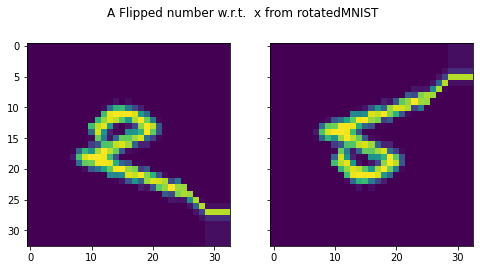

In [49]:
#Example of reflection w.r.t to x axis
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, squeeze=True, figsize=(8, 4))
axes[0].imshow(train_set.__getitem__(7)[0][0].numpy())
fig.suptitle('A Flipped number w.r.t.  x from rotatedMNIST')
axes[1].imshow(torch.flip(train_set.__getitem__(7)[0][0],[-2]))
plt.show()



In [28]:
def reflection(x: torch.Tensor, f: int) -> torch.Tensor:
  if f==1:
    y=torch.flip(x,[-2])
  else:
    y=x
  return y

def permutation_D4(y: torch.Tensor, r: int) -> torch.Tensor:
  # `y` is a function of p4m, basically have 't' a position and an orientation/reflection 'r'
  # the last two dimensions (`dim=-2` and `dim=-1`) of `y` are the spatial dimensions
  # `dim=-3` has size `8` and is the D_4 dimension.
  order=0
  rotoreflect_y=torch.empty(y.shape)
  permuted_y=torch.empty(y.shape) 
  if r<4:
    rotoreflect_y=rotate(y,r) 
    for i in range(8):
      permuted_y[...,D4.product(r,i),: ,:]=rotoreflect_y[...,i,:,:] # The permutation of index in according to the D4 Group
  if r>=4:
    order=4-r
    rotoreflect_y=reflection(rotate(y,order),1)
    for i in range(8):
      permuted_y[...,D4.inverse(D4.product(r,i)),: ,:]=rotoreflect_y[...,i,:,:] # The permutation of index in according to the D4 Group


  return permuted_y

Let's see if this operation is equivariant

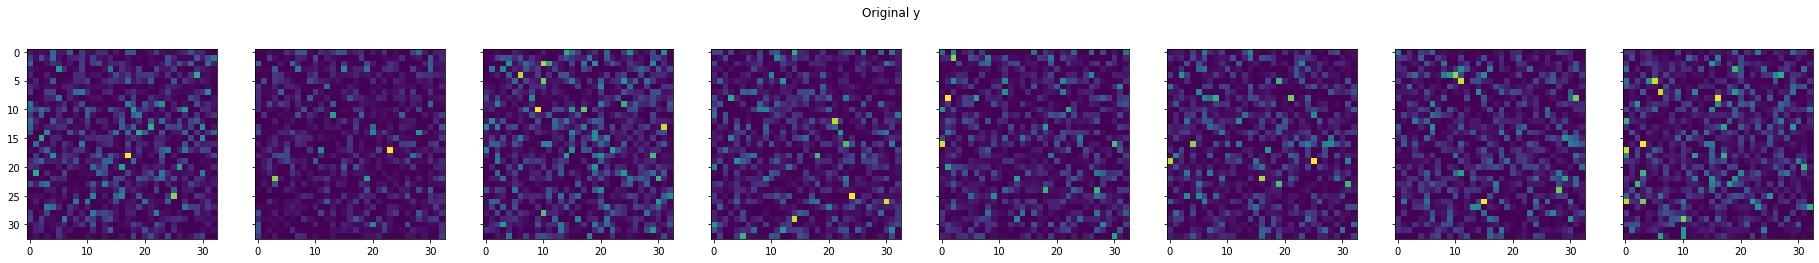

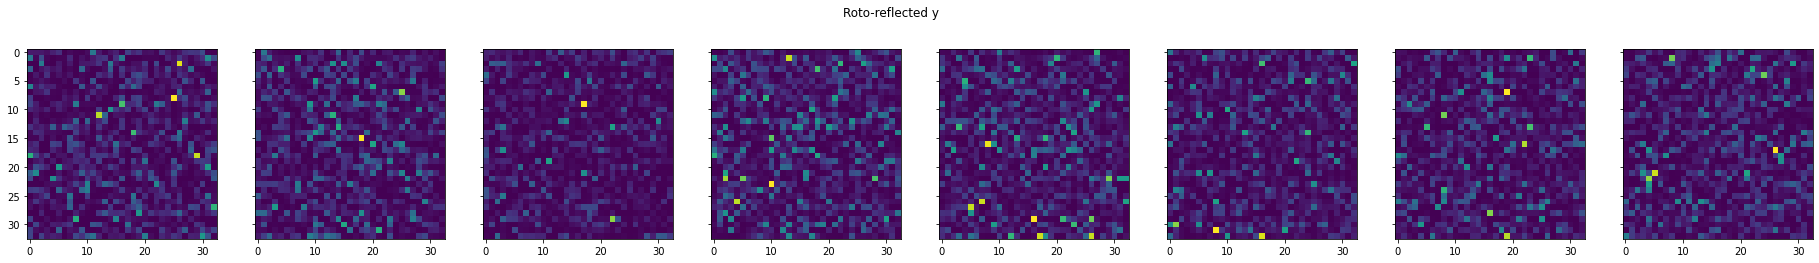

In [51]:
y = torch.randn(1, 1, 8, 33, 33)**2


ry = permutation_D4(y, 1)


fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(32, 4))
for i in range(8):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(32, 4))
for i in range(8):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Roto-reflected y')
plt.show()


The operations to keep in mind for a rotation of $1$ are the following for almost all the elements the rotation basically shift a single image of 1 position. exept for the fourth and last, that goes into position one and four.


We can check for instance that for a specific image the permutation is mapped correctly, in this case, the results must always be the same

torch.Size([33, 33])
torch.Size([8, 33, 33])


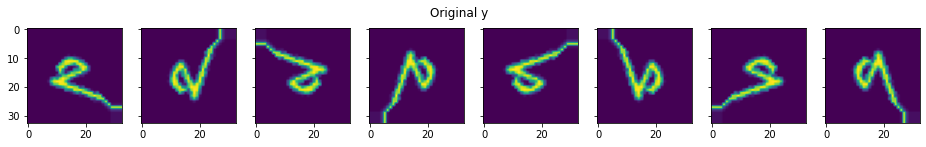

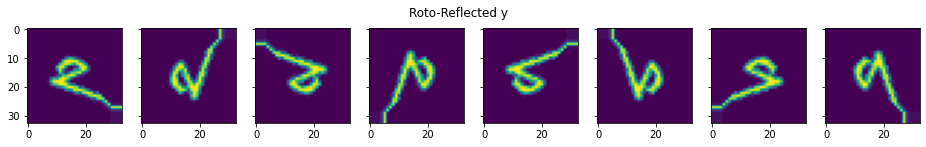

In [52]:
print(train_set.__getitem__(7)[0][0].shape)
a=train_set.__getitem__(7)[0][0]
b=reflection(a,1)
y=torch.stack((a,rotate(a,1),rotate(a,2),rotate(a,3),b,rotate(b,1),rotate(b,2),rotate(b,3)),dim=0)
print(y.shape)
d4y = permutation_D4(y,6)


fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  axes[i].imshow(y[i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  axes[i].imshow(d4y[i].numpy())
fig.suptitle('Roto-Reflected y')
plt.show()


#The fact that the same graph is obtained means that the index are permuted correctly

The fact that after a permutation the same figure is obtained in the correct position means that the permutation of the index is working correctly. Note that in the last images we have a reflection and after a rotation that correspond to a reflection w.r.t. different axes (horizontal, principal diagonal, vertical and antidiagonal directions starting from 4 to 8, that order depends on the `torch.flip` operation.)

---
##Lifting Convolution
Let's now implement, as seen before, the *lifting convolution* layer and the *group convolution* layer for this group. In the lifting layer the starting filter will be roto-reflected so the dimension of the final filter will be $8$

In [25]:
class D4LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(D4LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
  
    # weights inizialized with random values from a normal distribution with std = 1 / sqrt(out_channels * in_channels)

    self.weight = None

    self.weight=Parameter(torch.empty(self.out_channels*self.in_channels*self.kernel_size*self.kernel_size).normal_(mean=0,std=1/np.sqrt(self.out_channels*self.in_channels)))
    
    self.bias = None
    if bias:

      self.bias=Parameter(torch.empty(self.out_channels).normal_(mean=0,std=1/np.sqrt(self.out_channels)))
  
  def build_filter(self) ->torch.Tensor:
   
    # - the `out_channels x 8 x in_channels x kernel_size x kernel_size` filter
    # - the `out_channels x 8` bias
    
    _filter = None
    _bias = None

    filtro_base=self.weight.reshape(self.out_channels,self.in_channels, self.kernel_size,self.kernel_size)
    r=[rotate(filtro_base,i+1) for i in range(3)]
    reflected=reflection(filtro_base,1)
    r_R=[rotate(reflected,i+1) for i in range(3)]
    _filter= torch.stack((filtro_base,r[0],r[1],r[2],reflected,r_R[0],r_R[1],r_R[2]),dim=1)

    if self.bias is not None:
    
      _bias=torch.stack((self.bias,self.bias,self.bias,self.bias,self.bias,self.bias,self.bias,self.bias),dim=1) 

    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    if self.bias is not None:
      assert _bias.shape == (self.out_channels, 8)

    assert _filter.shape == (self.out_channels, 8, self.in_channels, self.kernel_size, self.kernel_size)

    # for use torch.conv2d,the filter and bias are reshaped in order to stack together all filters

    _filter = _filter.reshape(self.out_channels * 8, self.in_channels, self.kernel_size, self.kernel_size)

    if self.bias is not None:
      _bias = _bias.reshape(self.out_channels * 8)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*8 x W x H`
    # we need to reshape it to `batch_size x out_channels x 8 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 8, out.shape[-2], out.shape[-1])

Let's check if this layer is equivariant for roto-reflections. It must fulfill the relation:
$$
\Phi (T_g x) = T_g \Phi (x)
$$



In [54]:
#just some arbitrary dimensions..

in_channels = 1
out_channels = 5
kernel_size = 3
batchsize = 6
S = 33

layer = D4LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, S, S)

# the input image belongs to the space X, so we use the reflection, in the base used it correspond to the 4th element of the base
gx = reflection(x, 1) 

psi_x = layer(x) 
psi_gx = layer(gx)

# the output is a function in the space Y, for come back, we need to permute the layer for the same element used for gx, that is 4.
g_psi_x = permutation_D4(psi_x, 4)


# check equivariance (here i'm imposing the relation of equivariance seen before)
assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)
#this operation fulfuill the reflection. let's see for a generic roto-reflection

y = torch.randn(batchsize, in_channels, S, S)

layer = D4LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

gy=rotate((reflection(y,1)),1) #this is basically the last element of the base, rotated of 270 degrees and reflected.
psi_y=layer(y)
psi_gy= layer(gy)

g_psi_y=permutation_D4(psi_y,5)

assert torch.allclose(psi_gy, g_psi_y, atol=1e-6, rtol=1e-6)


Notice that applying a rotation and then a reflection is different from the opposite because the group $D_4$ is not abelian.
If we want to check the opposite, we must keep in mind that in this specific case
$$
R_{\frac{\pi}{2}} \cdot F = \cdot F \cdot R_{\frac{\pi}{2}}^{-1} = F  \cdot R_{\frac{3}{2}\pi}
$$
This element in our base will be equivalent to the 5, so if we invert the operation, the equivariance is anyway fulfilled.

In [55]:
y = torch.randn(batchsize, in_channels, S, S)

layer = D4LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

gy=reflection(rotate(y,3),1) #this element is not anymore espressed in our base, because is F*R, we are working with a sturcture of elemente R*F
#so this operation will be automatically converted in the base in we are working with (automatically done by the D4_product operation). In this way,
#the operations is always consistent.
psi_y=layer(y)
psi_gy= layer(gy)

g_psi_y=permutation_D4(psi_y,5) #here i put 5, not 7.

assert torch.allclose(psi_gy, g_psi_y, atol=1e-6, rtol=1e-6)

## D4 Group Convolution

The next step, is to build a layer that maps the filter from the lifted space $Y$ to the same space $Y$. 

In [21]:
class D4GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(D4GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
  
    self.weight = None
    #inizialized starting from a normal distribution, with an sd given by the dimension of input*output.

    self.weight=Parameter(torch.empty(self.out_channels*self.in_channels*8*self.kernel_size*self.kernel_size).normal_(0.,1/np.sqrt(self.out_channels*self.in_channels)))

    self.bias = None

    if bias:

      self.bias=Parameter(torch.empty(self.out_channels).normal_(mean=0,std=1/np.sqrt(self.out_channels))) 
  
  def build_filter(self) ->torch.Tensor:
    # - the `out_channels x 8 x in_channels x 8 x kernel_size x kernel_size` filter
    # - the `out_channels x 8` bias
    
    _filter = None
    _bias = None

    #in order to buid a matrix of filter 8x8 we need to correctly permute the single combination of filter for a given element of the base.

    filtro_base_rot_ref=self.weight.reshape(self.out_channels,self.in_channels,8,self.kernel_size,self.kernel_size)
    r=[permutation_D4(filtro_base_rot_ref,i+1) for i in range(7)]
    _filter=torch.stack((filtro_base_rot_ref,r[0],r[1],r[2],r[3],r[4],r[5],r[6]),dim=1)

    if self.bias is not None:

      _bias=torch.stack((self.bias,self.bias,self.bias,self.bias,self.bias,self.bias,self.bias,self.bias),dim=1) 
    
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()
    #stacking together the filters allow us to use torch.conv2d
    _filter = _filter.reshape(self.out_channels * 8, self.in_channels * 8, self.kernel_size, self.kernel_size)

    if self.bias is not None:
      _bias = _bias.reshape(self.out_channels * 8)

    # this time, the input has shape `batch_size x in_channels x 8 x W x H`, it is indeed an element of the space Y
    # in order to use torch.conv2d, the input must be reshaped as `batch_size x in_channels*8 x W x H` 
    x = x.view(x.shape[0], self.in_channels*8, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*8 x W x H`
    # `batch_size x out_channels x 8 x W x H` is the expected final shape 

    return out.view(-1, self.out_channels, 8, out.shape[-2], out.shape[-1])


Let's check  equivariance for this layer too:

In [57]:
#just some arbitrary dimensions..
in_channels = 3
out_channels = 10
kernel_size = 3
batchsize = 5
S = 33

layer = D4GroupConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, 8, S, S)**2
# the input image belongs to the space Y, this time the rotation must permute the index too.
gx = permutation_D4(x, 2)

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = permutation_D4(psi_x, 2)

# check equivariance (here i'm imposing the relation of equivariance seen before)
assert torch.allclose(psi_gx, g_psi_x, atol=1e-5, rtol=1e-5)

#Deep Equivariant CNN for D4 Group (p4mCNN)
It is finally possible to build a network as seen for the p4 group and test it on different dataset. In order to have a fair comparison here, we must keep in mind that the number of parameters here will be multiplied by a factor 8 in the 'D4GroupConv2d' layers, so we must renormalize the inputs dimension by a factor $\sqrt{8}\approx 3$. In this way, the number of weights of the network is similar to the p4CNN and to the classic CNN

##p4mCNN tested for CIFAR10
Let's try the performance of the D4CNN on the CIFAR10 dataset.

In [37]:
class D4CNNCifar(nn.Module):
  def __init__(self) -> None:
        super().__init__()
      # group convolutional layer, the first one is the lifting layer that increase the dimensions for the rotations of the filter.
        self.conv1=D4LiftingConv2d(3,5,3,padding=1)
        self.conv2=D4GroupConv2d(5,10,3,padding=1)
        self.conv3=D4GroupConv2d(10,21,3,padding=1)
        self.conv4=D4GroupConv2d(21,43,3,padding=1)
      #pooling layer here we have 2 type because after the last group conv we need to sum up the filter dimensions
        self.pool=nn.MaxPool3d(kernel_size=(1,2,2),stride=(1,2,2),padding=(0,0,0))
        self.final_pool=nn.MaxPool3d(kernel_size=(8,2,2),stride=(1,2,2),padding=(0,0,0))
      #connected layers
        self.fc1=nn.Linear(43*2*2,600)
        self.fc2=nn.Linear(600,64)
        self.fc3=nn.Linear(64,10)
      #dropout
        self.dropout=nn.Dropout(p=.5)  
  def forward(self,x):

      x = self.pool(F.relu(self.conv1(x)))   
      x = self.pool(F.relu(self.conv2(x))) 
      x = self.pool(F.relu(self.conv3(x))) 
      x = self.final_pool(F.relu(self.conv4(x))) 
      x = x.view(-1,43*2*2)
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x=self.fc3(x)

      return x

In [59]:
model_D4Cifar= D4CNNCifar()
model_D4Cifar.to(device)

print("Number of parameters:",sum(x.numel() for x in model_D4Cifar.parameters() if x.requires_grad))

Number of parameters: 226864


In [60]:
model_D4Cifar=train_Cifar(model_D4Cifar)
model_D4Cifar.load_state_dict(torch.load('model_cifar.pt'))

Training:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Training Loss :1.461419
Validation Loss :0.290167
Validation loss decreased (inf --> 0.290167).  Saving model ...


100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Training Loss :1.122950
Validation Loss :0.237805
Validation loss decreased (0.290167 --> 0.237805).  Saving model ...


100%|██████████| 625/625 [03:03<00:00,  3.40it/s]


Training Loss :0.940156
Validation Loss :0.216939
Validation loss decreased (0.237805 --> 0.216939).  Saving model ...


100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Training Loss :0.836124
Validation Loss :0.192065
Validation loss decreased (0.216939 --> 0.192065).  Saving model ...


100%|██████████| 625/625 [03:02<00:00,  3.42it/s]


Training Loss :0.753518
Validation Loss :0.189668
Validation loss decreased (0.192065 --> 0.189668).  Saving model ...


100%|██████████| 625/625 [03:02<00:00,  3.42it/s]


Training Loss :0.687584
Validation Loss :0.177287
Validation loss decreased (0.189668 --> 0.177287).  Saving model ...


100%|██████████| 625/625 [03:02<00:00,  3.43it/s]


Training Loss :0.640933
Validation Loss :0.185757


100%|██████████| 625/625 [03:02<00:00,  3.43it/s]


Training Loss :0.596983
Validation Loss :0.179701


100%|██████████| 625/625 [03:02<00:00,  3.43it/s]


Training Loss :0.553170
Validation Loss :0.186943


100%|██████████| 625/625 [03:02<00:00,  3.43it/s]


Training Loss :0.513618
Validation Loss :0.181015


100%|██████████| 625/625 [03:02<00:00,  3.43it/s]


Training Loss :0.490118
Validation Loss :0.184397


100%|██████████| 625/625 [03:02<00:00,  3.42it/s]


Training Loss :0.460928
Validation Loss :0.184324


100%|██████████| 625/625 [03:02<00:00,  3.42it/s]


Training Loss :0.435172
Validation Loss :0.193274


100%|██████████| 625/625 [03:03<00:00,  3.40it/s]


Training Loss :0.419891
Validation Loss :0.195607


100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Training Loss :0.382441
Validation Loss :0.208936


100%|██████████| 625/625 [03:03<00:00,  3.40it/s]


Training Loss :0.373493
Validation Loss :0.211519


100%|██████████| 625/625 [03:03<00:00,  3.41it/s]


Training Loss :0.352357
Validation Loss :0.221518


100%|██████████| 625/625 [03:03<00:00,  3.41it/s]


Training Loss :0.348318
Validation Loss :0.211047


100%|██████████| 625/625 [03:04<00:00,  3.40it/s]


Training Loss :0.326541
Validation Loss :0.230881


100%|██████████| 625/625 [03:03<00:00,  3.41it/s]


Training Loss :0.318015
Validation Loss :0.240679


100%|██████████| 625/625 [03:02<00:00,  3.43it/s]


Training Loss :0.301932
Validation Loss :0.241362


100%|██████████| 625/625 [03:02<00:00,  3.42it/s]


Training Loss :0.289491
Validation Loss :0.257955


100%|██████████| 625/625 [03:03<00:00,  3.41it/s]


Training Loss :0.280975
Validation Loss :0.247595


100%|██████████| 625/625 [03:04<00:00,  3.40it/s]


Training Loss :0.272126
Validation Loss :0.262043


100%|██████████| 625/625 [03:03<00:00,  3.41it/s]


Training Loss :0.264249
Validation Loss :0.282594


100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Training Loss :0.250322
Validation Loss :0.258175


100%|██████████| 625/625 [03:04<00:00,  3.40it/s]


Training Loss :0.243509
Validation Loss :0.275515


100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Training Loss :0.244145
Validation Loss :0.299820


100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Training Loss :0.239300
Validation Loss :0.269570


100%|██████████| 625/625 [03:06<00:00,  3.36it/s]


Training Loss :0.223184
Validation Loss :0.276871


<All keys matched successfully>

In [61]:
test_Cifar(model_D4Cifar)

Test Accuracy of plane: 70% (705/1000)
Test Accuracy of   car: 82% (822/1000)
Test Accuracy of  bird: 52% (527/1000)
Test Accuracy of   cat: 45% (457/1000)
Test Accuracy of  deer: 68% (685/1000)
Test Accuracy of   dog: 53% (533/1000)
Test Accuracy of  frog: 83% (837/1000)
Test Accuracy of horse: 75% (752/1000)
Test Accuracy of  ship: 86% (867/1000)
Test Accuracy of truck: 83% (831/1000)

Test Accuracy (Overall): 70% (7016/10000)


# Cifar10+
Cifar10+ is the Cifar10 dataset augmented with some horizontal reflections and traslations. We want to test the performance of the networks in the case of data augmentations

---
Let's start by applying to the vanilla Cifar10 the operations described before: 

In [23]:
transform_plus = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomAffine(0, translate=(0.1,0.1)) 
    ])
                      


train_data = datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=transform_plus)

test_data = datasets.CIFAR10(
        "../data",
        train=False,
        download=True,
        transform=transform_plus)



output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


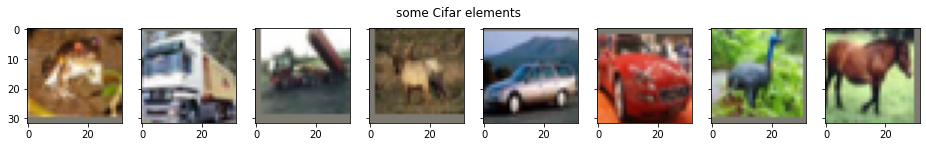

In [14]:
fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2023, 0.1994, 0.2010])
  image, label = train_data[i]
  image_example = image.numpy().transpose((1, 2, 0))
  image_example= std * image_example + mean
  image_example= np.clip(image_example, 0, 1) 
  axes[i].imshow(image_example)
fig.suptitle('some Cifar elements')
plt.show()

Let's now test the performance of the vanilla CNN and the others on the Cifar10 augumented dataset.

In [19]:
#Vanilla CNN
epochs=20
model= CNNCifar()
model.to(device)
model_=train_Cifar(model)
model.load_state_dict(torch.load('model_cifar.pt'))
test_Cifar(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:58<00:00, 10.63it/s]


Training Loss :1.486961
Validation Loss :0.307897
Validation loss decreased (inf --> 0.307897).  Saving model ...


100%|██████████| 625/625 [00:58<00:00, 10.64it/s]


Training Loss :1.195596
Validation Loss :0.258419
Validation loss decreased (0.307897 --> 0.258419).  Saving model ...


100%|██████████| 625/625 [01:00<00:00, 10.40it/s]


Training Loss :1.061901
Validation Loss :0.231922
Validation loss decreased (0.258419 --> 0.231922).  Saving model ...


100%|██████████| 625/625 [01:01<00:00, 10.14it/s]


Training Loss :0.970359
Validation Loss :0.234023


100%|██████████| 625/625 [01:02<00:00,  9.98it/s]


Training Loss :0.907392
Validation Loss :0.206529
Validation loss decreased (0.231922 --> 0.206529).  Saving model ...


100%|██████████| 625/625 [01:04<00:00,  9.76it/s]


Training Loss :0.859202
Validation Loss :0.198987
Validation loss decreased (0.206529 --> 0.198987).  Saving model ...


100%|██████████| 625/625 [01:05<00:00,  9.49it/s]


Training Loss :0.814399
Validation Loss :0.188923
Validation loss decreased (0.198987 --> 0.188923).  Saving model ...


100%|██████████| 625/625 [01:05<00:00,  9.52it/s]


Training Loss :0.788295
Validation Loss :0.181441
Validation loss decreased (0.188923 --> 0.181441).  Saving model ...


100%|██████████| 625/625 [01:05<00:00,  9.57it/s]


Training Loss :0.759917
Validation Loss :0.172483
Validation loss decreased (0.181441 --> 0.172483).  Saving model ...


100%|██████████| 625/625 [01:06<00:00,  9.37it/s]


Training Loss :0.732787
Validation Loss :0.183722


100%|██████████| 625/625 [01:07<00:00,  9.22it/s]


Training Loss :0.723592
Validation Loss :0.164045
Validation loss decreased (0.172483 --> 0.164045).  Saving model ...


100%|██████████| 625/625 [01:09<00:00,  9.00it/s]


Training Loss :0.694413
Validation Loss :0.163710
Validation loss decreased (0.164045 --> 0.163710).  Saving model ...


100%|██████████| 625/625 [01:10<00:00,  8.90it/s]


Training Loss :0.687685
Validation Loss :0.161276
Validation loss decreased (0.163710 --> 0.161276).  Saving model ...


100%|██████████| 625/625 [01:12<00:00,  8.66it/s]


Training Loss :0.671441
Validation Loss :0.160556
Validation loss decreased (0.161276 --> 0.160556).  Saving model ...


100%|██████████| 625/625 [01:16<00:00,  8.15it/s]


Training Loss :0.656335
Validation Loss :0.159536
Validation loss decreased (0.160556 --> 0.159536).  Saving model ...


100%|██████████| 625/625 [01:21<00:00,  7.66it/s]


Training Loss :0.649153
Validation Loss :0.153950
Validation loss decreased (0.159536 --> 0.153950).  Saving model ...


100%|██████████| 625/625 [01:26<00:00,  7.21it/s]


Training Loss :0.637733
Validation Loss :0.164127


100%|██████████| 625/625 [01:31<00:00,  6.81it/s]


Training Loss :0.626508
Validation Loss :0.157286


100%|██████████| 625/625 [01:35<00:00,  6.54it/s]


Training Loss :0.624034
Validation Loss :0.152998
Validation loss decreased (0.153950 --> 0.152998).  Saving model ...


100%|██████████| 625/625 [01:38<00:00,  6.32it/s]


Training Loss :0.608251
Validation Loss :0.159157
Test Accuracy of plane: 82% (828/1000)
Test Accuracy of   car: 91% (912/1000)
Test Accuracy of  bird: 56% (567/1000)
Test Accuracy of   cat: 59% (597/1000)
Test Accuracy of  deer: 63% (633/1000)
Test Accuracy of   dog: 65% (650/1000)
Test Accuracy of  frog: 82% (826/1000)
Test Accuracy of horse: 78% (786/1000)
Test Accuracy of  ship: 86% (864/1000)
Test Accuracy of truck: 70% (700/1000)

Test Accuracy (Overall): 73% (7363/10000)


In [65]:
#p4CNN
model= p4CNNCifar()
model.to(device)
model_=train_Cifar(model)
model.load_state_dict(torch.load('model_cifar.pt'))
test_Cifar(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 625/625 [02:15<00:00,  4.63it/s]


Training Loss :1.513062
Validation Loss :0.300685
Validation loss decreased (inf --> 0.300685).  Saving model ...


100%|██████████| 625/625 [02:14<00:00,  4.65it/s]


Training Loss :1.153793
Validation Loss :0.250976
Validation loss decreased (0.300685 --> 0.250976).  Saving model ...


100%|██████████| 625/625 [02:15<00:00,  4.62it/s]


Training Loss :1.004431
Validation Loss :0.219127
Validation loss decreased (0.250976 --> 0.219127).  Saving model ...


100%|██████████| 625/625 [02:15<00:00,  4.60it/s]


Training Loss :0.906665
Validation Loss :0.206750
Validation loss decreased (0.219127 --> 0.206750).  Saving model ...


100%|██████████| 625/625 [02:15<00:00,  4.60it/s]


Training Loss :0.845663
Validation Loss :0.195830
Validation loss decreased (0.206750 --> 0.195830).  Saving model ...


100%|██████████| 625/625 [02:16<00:00,  4.59it/s]


Training Loss :0.800274
Validation Loss :0.176815
Validation loss decreased (0.195830 --> 0.176815).  Saving model ...


100%|██████████| 625/625 [02:16<00:00,  4.59it/s]


Training Loss :0.760254
Validation Loss :0.184317


100%|██████████| 625/625 [02:16<00:00,  4.58it/s]


Training Loss :0.736932
Validation Loss :0.169295
Validation loss decreased (0.176815 --> 0.169295).  Saving model ...


100%|██████████| 625/625 [02:17<00:00,  4.56it/s]


Training Loss :0.705994
Validation Loss :0.172980


100%|██████████| 625/625 [02:17<00:00,  4.55it/s]


Training Loss :0.697913
Validation Loss :0.162314
Validation loss decreased (0.169295 --> 0.162314).  Saving model ...


100%|██████████| 625/625 [02:17<00:00,  4.55it/s]


Training Loss :0.676866
Validation Loss :0.159362
Validation loss decreased (0.162314 --> 0.159362).  Saving model ...


100%|██████████| 625/625 [02:17<00:00,  4.54it/s]


Training Loss :0.667816
Validation Loss :0.155346
Validation loss decreased (0.159362 --> 0.155346).  Saving model ...


100%|██████████| 625/625 [02:18<00:00,  4.51it/s]


Training Loss :0.646415
Validation Loss :0.159244


100%|██████████| 625/625 [02:19<00:00,  4.47it/s]


Training Loss :0.635581
Validation Loss :0.155360


100%|██████████| 625/625 [02:20<00:00,  4.46it/s]


Training Loss :0.628713
Validation Loss :0.148177
Validation loss decreased (0.155346 --> 0.148177).  Saving model ...


100%|██████████| 625/625 [02:21<00:00,  4.43it/s]


Training Loss :0.617176
Validation Loss :0.146528
Validation loss decreased (0.148177 --> 0.146528).  Saving model ...


100%|██████████| 625/625 [02:17<00:00,  4.54it/s]


Training Loss :0.604828
Validation Loss :0.145663
Validation loss decreased (0.146528 --> 0.145663).  Saving model ...


100%|██████████| 625/625 [02:18<00:00,  4.52it/s]


Training Loss :0.597612
Validation Loss :0.148833


100%|██████████| 625/625 [02:19<00:00,  4.48it/s]


Training Loss :0.592099
Validation Loss :0.147776


100%|██████████| 625/625 [02:20<00:00,  4.46it/s]


Training Loss :0.583268
Validation Loss :0.149237
Test Accuracy of plane: 84% (842/1000)
Test Accuracy of   car: 84% (845/1000)
Test Accuracy of  bird: 65% (653/1000)
Test Accuracy of   cat: 57% (575/1000)
Test Accuracy of  deer: 64% (642/1000)
Test Accuracy of   dog: 63% (631/1000)
Test Accuracy of  frog: 85% (856/1000)
Test Accuracy of horse: 79% (796/1000)
Test Accuracy of  ship: 76% (768/1000)
Test Accuracy of truck: 89% (892/1000)

Test Accuracy (Overall): 75% (7500/10000)


In [29]:
#p4mCNN
model= D4CNNCifar()
model.to(device)
model_=train_Cifar(model)
model.load_state_dict(torch.load('model_cifar.pt'))
test_Cifar(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 625/625 [02:54<00:00,  3.59it/s]


Training Loss :1.563359
Validation Loss :0.314141
Validation loss decreased (inf --> 0.314141).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.60it/s]


Training Loss :1.246853
Validation Loss :0.271478
Validation loss decreased (0.314141 --> 0.271478).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.60it/s]


Training Loss :1.102092
Validation Loss :0.236583
Validation loss decreased (0.271478 --> 0.236583).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.61it/s]


Training Loss :0.993034
Validation Loss :0.223975
Validation loss decreased (0.236583 --> 0.223975).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.60it/s]


Training Loss :0.929182
Validation Loss :0.225515


100%|██████████| 625/625 [02:52<00:00,  3.61it/s]


Training Loss :0.868976
Validation Loss :0.197279
Validation loss decreased (0.223975 --> 0.197279).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.829553
Validation Loss :0.204939


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.789901
Validation Loss :0.188517
Validation loss decreased (0.197279 --> 0.188517).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.59it/s]


Training Loss :0.763616
Validation Loss :0.179629
Validation loss decreased (0.188517 --> 0.179629).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.729370
Validation Loss :0.181501


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.712471
Validation Loss :0.172227
Validation loss decreased (0.179629 --> 0.172227).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.61it/s]


Training Loss :0.689138
Validation Loss :0.172903


100%|██████████| 625/625 [02:52<00:00,  3.61it/s]


Training Loss :0.675532
Validation Loss :0.166512
Validation loss decreased (0.172227 --> 0.166512).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.661400
Validation Loss :0.166741


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.651821
Validation Loss :0.162495
Validation loss decreased (0.166512 --> 0.162495).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.61it/s]


Training Loss :0.632171
Validation Loss :0.166295


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.627683
Validation Loss :0.162548


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.613375
Validation Loss :0.161281
Validation loss decreased (0.162495 --> 0.161281).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.61it/s]


Training Loss :0.606273
Validation Loss :0.154947
Validation loss decreased (0.161281 --> 0.154947).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.60it/s]


Training Loss :0.597013
Validation Loss :0.150863
Validation loss decreased (0.154947 --> 0.150863).  Saving model ...
Test Accuracy of plane: 84% (847/1000)
Test Accuracy of   car: 87% (878/1000)
Test Accuracy of  bird: 51% (512/1000)
Test Accuracy of   cat: 49% (497/1000)
Test Accuracy of  deer: 75% (757/1000)
Test Accuracy of   dog: 61% (616/1000)
Test Accuracy of  frog: 86% (861/1000)
Test Accuracy of horse: 77% (773/1000)
Test Accuracy of  ship: 86% (866/1000)
Test Accuracy of truck: 83% (832/1000)

Test Accuracy (Overall): 74% (7439/10000)


#Cifar10 with rotations
Let's see if in the case of rotations the performance for the p4CNN and p4mCNN change w.r.t. to the vanilla ones.

In [30]:
transform_rot = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
      transforms.RandomHorizontalFlip(p=0.5),
     #the first number allow a rotation in the range [-degrees,+degrees]
      transforms.RandomAffine(degrees=180, translate=(0.1,0.1)) 
    ])
            

train_data = datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=transform_rot)

test_data = datasets.CIFAR10(
        "../data",
        train=False,
        download=True,
        transform=transform_rot)


Files already downloaded and verified
Files already downloaded and verified


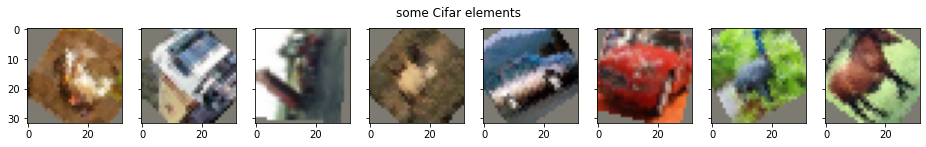

In [31]:
fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2023, 0.1994, 0.2010])
  image, label = train_data[i]
  image_example = image.numpy().transpose((1, 2, 0))
  image_example= std * image_example + mean
  image_example= np.clip(image_example, 0, 1) 
  axes[i].imshow(image_example)
fig.suptitle('some Cifar elements')
plt.show()

In [33]:
epochs=20
model= CNNCifar()
model.to(device)
model_=train_Cifar(model)
model.load_state_dict(torch.load('model_cifar.pt'))
test_Cifar(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:56<00:00, 11.11it/s]


Training Loss :1.644444
Validation Loss :0.375300
Validation loss decreased (inf --> 0.375300).  Saving model ...


100%|██████████| 625/625 [00:56<00:00, 11.05it/s]


Training Loss :1.497289
Validation Loss :0.354056
Validation loss decreased (0.375300 --> 0.354056).  Saving model ...


100%|██████████| 625/625 [01:00<00:00, 10.39it/s]


Training Loss :1.433270
Validation Loss :0.342617
Validation loss decreased (0.354056 --> 0.342617).  Saving model ...


100%|██████████| 625/625 [01:05<00:00,  9.61it/s]


Training Loss :1.385601
Validation Loss :0.332321
Validation loss decreased (0.342617 --> 0.332321).  Saving model ...


100%|██████████| 625/625 [01:06<00:00,  9.34it/s]


Training Loss :1.346090
Validation Loss :0.321512
Validation loss decreased (0.332321 --> 0.321512).  Saving model ...


100%|██████████| 625/625 [01:08<00:00,  9.12it/s]


Training Loss :1.311400
Validation Loss :0.314429
Validation loss decreased (0.321512 --> 0.314429).  Saving model ...


100%|██████████| 625/625 [01:09<00:00,  8.97it/s]


Training Loss :1.282920
Validation Loss :0.299923
Validation loss decreased (0.314429 --> 0.299923).  Saving model ...


100%|██████████| 625/625 [01:10<00:00,  8.81it/s]


Training Loss :1.253017
Validation Loss :0.297110
Validation loss decreased (0.299923 --> 0.297110).  Saving model ...


100%|██████████| 625/625 [01:12<00:00,  8.65it/s]


Training Loss :1.236580
Validation Loss :0.300338


100%|██████████| 625/625 [01:11<00:00,  8.70it/s]


Training Loss :1.215132
Validation Loss :0.287301
Validation loss decreased (0.297110 --> 0.287301).  Saving model ...


100%|██████████| 625/625 [01:13<00:00,  8.51it/s]


Training Loss :1.200723
Validation Loss :0.278990
Validation loss decreased (0.287301 --> 0.278990).  Saving model ...


100%|██████████| 625/625 [01:13<00:00,  8.48it/s]


Training Loss :1.188555
Validation Loss :0.279705


100%|██████████| 625/625 [01:17<00:00,  8.10it/s]


Training Loss :1.171007
Validation Loss :0.276445
Validation loss decreased (0.278990 --> 0.276445).  Saving model ...


100%|██████████| 625/625 [01:22<00:00,  7.58it/s]


Training Loss :1.165152
Validation Loss :0.273411
Validation loss decreased (0.276445 --> 0.273411).  Saving model ...


100%|██████████| 625/625 [01:27<00:00,  7.15it/s]


Training Loss :1.154882
Validation Loss :0.270272
Validation loss decreased (0.273411 --> 0.270272).  Saving model ...


100%|██████████| 625/625 [01:34<00:00,  6.59it/s]


Training Loss :1.147172
Validation Loss :0.271427


100%|██████████| 625/625 [01:41<00:00,  6.17it/s]


Training Loss :1.131981
Validation Loss :0.270550


100%|██████████| 625/625 [01:48<00:00,  5.79it/s]


Training Loss :1.126076
Validation Loss :0.263526
Validation loss decreased (0.270272 --> 0.263526).  Saving model ...


100%|██████████| 625/625 [01:56<00:00,  5.38it/s]


Training Loss :1.122555
Validation Loss :0.264703


100%|██████████| 625/625 [02:00<00:00,  5.17it/s]


Training Loss :1.114933
Validation Loss :0.264925
Test Accuracy of plane: 58% (581/1000)
Test Accuracy of   car: 64% (649/1000)
Test Accuracy of  bird: 26% (265/1000)
Test Accuracy of   cat: 32% (323/1000)
Test Accuracy of  deer: 55% (550/1000)
Test Accuracy of   dog: 48% (483/1000)
Test Accuracy of  frog: 61% (614/1000)
Test Accuracy of horse: 53% (531/1000)
Test Accuracy of  ship: 61% (614/1000)
Test Accuracy of truck: 60% (607/1000)

Test Accuracy (Overall): 52% (5217/10000)


In [36]:
#p4CNN
model= p4CNNCifar()
model.to(device)
model_=train_Cifar(model)
model.load_state_dict(torch.load('model_cifar.pt'))
test_Cifar(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 625/625 [01:49<00:00,  5.71it/s]


Training Loss :1.604322
Validation Loss :0.356996
Validation loss decreased (inf --> 0.356996).  Saving model ...


100%|██████████| 625/625 [01:49<00:00,  5.68it/s]


Training Loss :1.363353
Validation Loss :0.299396
Validation loss decreased (0.356996 --> 0.299396).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.67it/s]


Training Loss :1.250062
Validation Loss :0.288003
Validation loss decreased (0.299396 --> 0.288003).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.64it/s]


Training Loss :1.188761
Validation Loss :0.271814
Validation loss decreased (0.288003 --> 0.271814).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.64it/s]


Training Loss :1.147336
Validation Loss :0.267606
Validation loss decreased (0.271814 --> 0.267606).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.66it/s]


Training Loss :1.113769
Validation Loss :0.263157
Validation loss decreased (0.267606 --> 0.263157).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.66it/s]


Training Loss :1.087555
Validation Loss :0.256581
Validation loss decreased (0.263157 --> 0.256581).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.64it/s]


Training Loss :1.065092
Validation Loss :0.249943
Validation loss decreased (0.256581 --> 0.249943).  Saving model ...


100%|██████████| 625/625 [01:49<00:00,  5.70it/s]


Training Loss :1.040871
Validation Loss :0.245614
Validation loss decreased (0.249943 --> 0.245614).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.66it/s]


Training Loss :1.028382
Validation Loss :0.241805
Validation loss decreased (0.245614 --> 0.241805).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.67it/s]


Training Loss :1.010697
Validation Loss :0.236772
Validation loss decreased (0.241805 --> 0.236772).  Saving model ...


100%|██████████| 625/625 [01:50<00:00,  5.65it/s]


Training Loss :1.001632
Validation Loss :0.231479
Validation loss decreased (0.236772 --> 0.231479).  Saving model ...


100%|██████████| 625/625 [01:52<00:00,  5.56it/s]


Training Loss :0.988489
Validation Loss :0.234916


100%|██████████| 625/625 [01:52<00:00,  5.56it/s]


Training Loss :0.979653
Validation Loss :0.229091
Validation loss decreased (0.231479 --> 0.229091).  Saving model ...


100%|██████████| 625/625 [01:52<00:00,  5.56it/s]


Training Loss :0.970011
Validation Loss :0.230198


100%|██████████| 625/625 [01:53<00:00,  5.51it/s]


Training Loss :0.956169
Validation Loss :0.226098
Validation loss decreased (0.229091 --> 0.226098).  Saving model ...


100%|██████████| 625/625 [01:56<00:00,  5.38it/s]


Training Loss :0.955688
Validation Loss :0.225142
Validation loss decreased (0.226098 --> 0.225142).  Saving model ...


100%|██████████| 625/625 [01:56<00:00,  5.37it/s]


Training Loss :0.944982
Validation Loss :0.223153
Validation loss decreased (0.225142 --> 0.223153).  Saving model ...


100%|██████████| 625/625 [01:54<00:00,  5.47it/s]


Training Loss :0.943424
Validation Loss :0.226607


100%|██████████| 625/625 [01:57<00:00,  5.33it/s]


Training Loss :0.933204
Validation Loss :0.222733
Validation loss decreased (0.223153 --> 0.222733).  Saving model ...
Test Accuracy of plane: 63% (638/1000)
Test Accuracy of   car: 81% (818/1000)
Test Accuracy of  bird: 40% (402/1000)
Test Accuracy of   cat: 45% (450/1000)
Test Accuracy of  deer: 62% (624/1000)
Test Accuracy of   dog: 43% (436/1000)
Test Accuracy of  frog: 80% (806/1000)
Test Accuracy of horse: 55% (557/1000)
Test Accuracy of  ship: 72% (720/1000)
Test Accuracy of truck: 61% (619/1000)

Test Accuracy (Overall): 60% (6070/10000)


In [38]:
#p4mCNN
model= D4CNNCifar()
model.to(device)
model_=train_Cifar(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 625/625 [02:50<00:00,  3.66it/s]


Training Loss :1.600213
Validation Loss :0.343716
Validation loss decreased (inf --> 0.343716).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.329285
Validation Loss :0.299585
Validation loss decreased (0.343716 --> 0.299585).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.214042
Validation Loss :0.282840
Validation loss decreased (0.299585 --> 0.282840).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.145518
Validation Loss :0.260048
Validation loss decreased (0.282840 --> 0.260048).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.090016
Validation Loss :0.251059
Validation loss decreased (0.260048 --> 0.251059).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.057307
Validation Loss :0.244880
Validation loss decreased (0.251059 --> 0.244880).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.025825
Validation Loss :0.237560
Validation loss decreased (0.244880 --> 0.237560).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :1.008646
Validation Loss :0.237384
Validation loss decreased (0.237560 --> 0.237384).  Saving model ...


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :0.986627
Validation Loss :0.231736
Validation loss decreased (0.237384 --> 0.231736).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.968017
Validation Loss :0.228545
Validation loss decreased (0.231736 --> 0.228545).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.63it/s]


Training Loss :0.956525
Validation Loss :0.221396
Validation loss decreased (0.228545 --> 0.221396).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.63it/s]


Training Loss :0.943897
Validation Loss :0.224210


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :0.932661
Validation Loss :0.219891
Validation loss decreased (0.221396 --> 0.219891).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.61it/s]


Training Loss :0.917747
Validation Loss :0.213432
Validation loss decreased (0.219891 --> 0.213432).  Saving model ...


100%|██████████| 625/625 [02:53<00:00,  3.60it/s]


Training Loss :0.911288
Validation Loss :0.220115


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Training Loss :0.897750
Validation Loss :0.210500
Validation loss decreased (0.213432 --> 0.210500).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.63it/s]


Training Loss :0.895551
Validation Loss :0.214868


100%|██████████| 625/625 [02:52<00:00,  3.63it/s]


Training Loss :0.885448
Validation Loss :0.213991


100%|██████████| 625/625 [02:52<00:00,  3.63it/s]


Training Loss :0.880143
Validation Loss :0.207374
Validation loss decreased (0.210500 --> 0.207374).  Saving model ...


100%|██████████| 625/625 [02:52<00:00,  3.62it/s]


Training Loss :0.870883
Validation Loss :0.206888
Validation loss decreased (0.207374 --> 0.206888).  Saving model ...


In [39]:
model.load_state_dict(torch.load('model_cifar.pt'))
test_Cifar(model)

Test Accuracy of plane: 78% (781/1000)
Test Accuracy of   car: 78% (786/1000)
Test Accuracy of  bird: 49% (492/1000)
Test Accuracy of   cat: 37% (371/1000)
Test Accuracy of  deer: 57% (579/1000)
Test Accuracy of   dog: 61% (617/1000)
Test Accuracy of  frog: 63% (635/1000)
Test Accuracy of horse: 68% (680/1000)
Test Accuracy of  ship: 73% (739/1000)
Test Accuracy of truck: 73% (731/1000)

Test Accuracy (Overall): 64% (6411/10000)


#Conclusions
The performances of the networks seems to improve after the implementation of the p4CNN of MNIST and even on Cifar10 during different simulations the errors seems to be in average the same as standard CNNs. For what concerns the data augmentation, the performances seems to increase w.r.t to the standard CNNs both for p4CNN and p4mCNN (in some simulation lass than others but typically they does). Another important result is the one related to Cifar10+ with rotations, where the p4CNN and p4mCNN reach results far better than the standard CNN. This can be due to the fact that the group convolution achieve better generalization if partial symmetries that are encoded in the networks shows off in the data (That is basically the same conclusion as Cohen, https://arxiv.org/pdf/1602.07576.pdf).  In this case the difference is bigger and the group convolution seems to be more robust than the standard networks.